In [1]:
pip install -q adjustText

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [3]:
# Load the scores
df = pd.read_csv('model_scores.csv', index_col='Model')
models = df.index.tolist()
metrics = df.columns.tolist()
x = np.arange(len(metrics))
n_models = len(models)
jitter_width = 0.2  # total spread for line plot

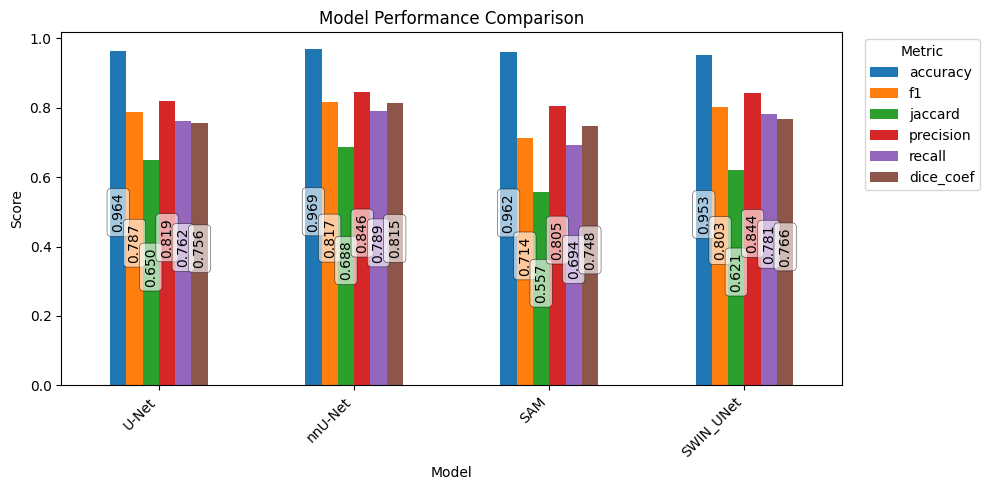

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
df.plot(kind='bar', ax=ax)
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.set_xticklabels(df.index, rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.3f',
        label_type='center',
        rotation=90,        # vertical text
        padding=4,          # extra space so it doesn’t overlap the bar
        bbox=dict(
            boxstyle='round,pad=0.3',
            fc='white',
            alpha=0.6,
            linewidth=0.5
        )
    )

ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


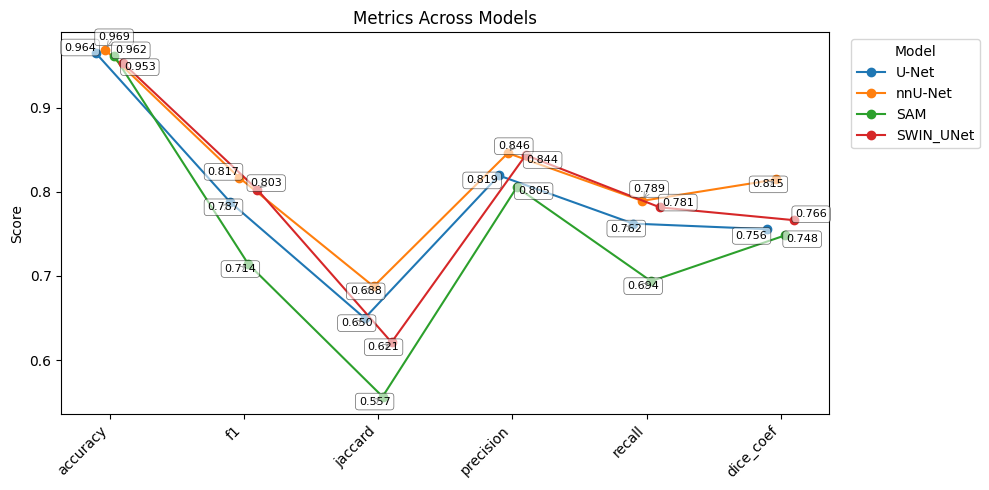

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
texts = []

for idx, model in enumerate(models):
    xi = x + (idx - (n_models-1)/2) * (jitter_width / (n_models-1))
    yi = df.loc[model].values

    ax.plot(xi, yi, marker='o', label=model)

    for xpt, ypt in zip(xi, yi):
        texts.append(
            ax.text(
                xpt, ypt, f'{ypt:.3f}',
                fontsize=8,
                ha='center', va='center',
                bbox=dict(
                    boxstyle='round,pad=0.3',
                    fc='white',
                    alpha=0.6,
                    linewidth=0.5
                )
            )
        )

adjust_text(
    texts,
    only_move={'points':'y', 'texts':'y'},
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2)
)

ax.set_title('Metrics Across Models')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import friedmanchisquare
import itertools

In [7]:
# ----------------------------------------------------------------------------
# DESCRIPTIVE STATISTICS per model
# ----------------------------------------------------------------------------
summary = pd.DataFrame({
    'mean': df.mean(axis=1),
    'std':  df.std(axis=1),
    'min':  df.min(axis=1),
    'max':  df.max(axis=1)
})
print("\n=== Descriptive statistics per model ===")
print(summary.round(4))


=== Descriptive statistics per model ===
             mean     std     min     max
Model                                    
U-Net      0.7898  0.1028  0.6498  0.9643
nnU-Net    0.8204  0.0909  0.6876  0.9688
SAM        0.7466  0.1339  0.5567  0.9616
SWIN_UNet  0.7946  0.1082  0.6212  0.9527


In [8]:
# ----------------------------------------------------------------------------
# FRIEDMAN TEST across models
# ----------------------------------------------------------------------------
stat, pval = friedmanchisquare(*(df.loc[m] for m in models))
print(f"\nFriedman’s test: χ² = {stat:.3f}, p = {pval:.3f}")


Friedman’s test: χ² = 14.600, p = 0.002


In [9]:
# ----------------------------------------------------------------------------
# CORRELATION MATRICES
# ----------------------------------------------------------------------------
corr_models  = df.T.corr()
corr_metrics = df.corr()

print("\n=== Correlation between MODELS (across metrics) ===")
print(corr_models.round(3))

print("\n=== Correlation between METRICS (across models) ===")
print(corr_metrics.round(3))


=== Correlation between MODELS (across metrics) ===
Model      U-Net  nnU-Net    SAM  SWIN_UNet
Model                                      
U-Net      1.000    0.991  0.978      0.982
nnU-Net    0.991    1.000  0.992      0.982
SAM        0.978    0.992  1.000      0.969
SWIN_UNet  0.982    0.982  0.969      1.000

=== Correlation between METRICS (across models) ===
           accuracy     f1  jaccard  precision  recall  dice_coef
accuracy      1.000  0.086    0.484     -0.088   0.030      0.516
f1            0.086  1.000    0.911      0.908   0.998      0.701
jaccard       0.484  0.911    1.000      0.735   0.886      0.790
precision    -0.088  0.908    0.735      1.000   0.919      0.771
recall        0.030  0.998    0.886      0.919   1.000      0.679
dice_coef     0.516  0.701    0.790      0.771   0.679      1.000


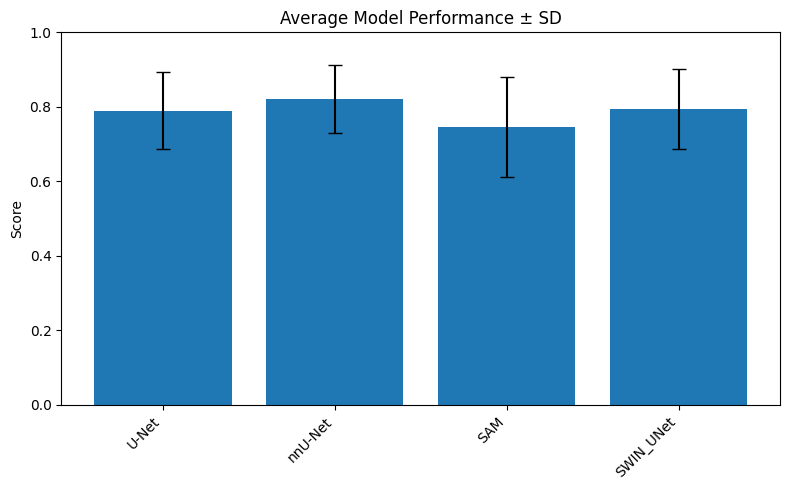

In [10]:
# ----------------------------------------------------------------------------
# PLOT mean ± std as a bar chart
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(summary.index, summary['mean'], yerr=summary['std'], capsize=5)
ax.set_title('Average Model Performance ± SD')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)  # scores are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

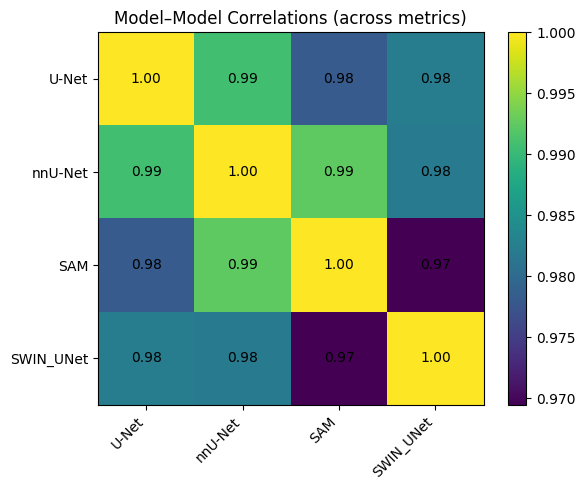

In [11]:
# ----------------------------------------------------------------------------
# HEATMAP: Correlation between MODELS
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr_models.values, aspect='auto', interpolation='none')
ax.set_title('Model–Model Correlations (across metrics)')
ax.set_xticks(np.arange(n_models))
ax.set_yticks(np.arange(n_models))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_yticklabels(models)
# annotate cells
for i in range(n_models):
    for j in range(n_models):
        ax.text(j, i, f"{corr_models.values[i, j]:.2f}",
                ha='center', va='center')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

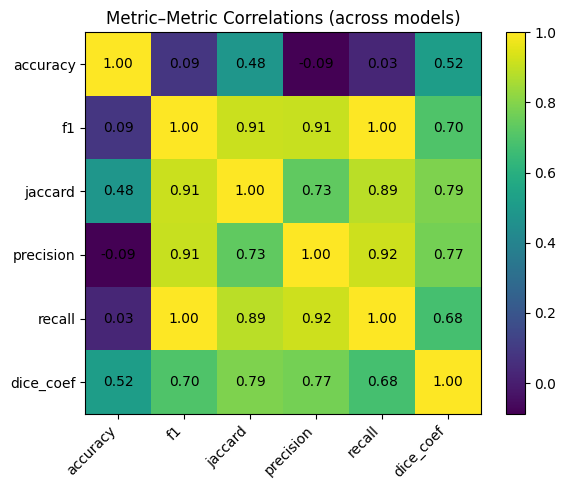

In [12]:
# ----------------------------------------------------------------------------
# HEATMAP: Correlation between METRICS
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr_metrics.values, aspect='auto', interpolation='none')
ax.set_title('Metric–Metric Correlations (across models)')
ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_yticklabels(metrics)
# annotate cells
for i in range(len(metrics)):
    for j in range(len(metrics)):
        ax.text(j, i, f"{corr_metrics.values[i, j]:.2f}",
                ha='center', va='center')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()